In [ ]:
# !{sys.executable} -m pip install python-docx

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import time
import math
import os
import sys
import bghelperfunctions as bg
from bghelperfunctions import TimeBandTargets
import scipy.ndimage.measurements as im_meas
from mpl_toolkits.axes_grid1 import make_axes_locatable
from docx import Document
from docx.shared import Inches

%matplotlib inline
plt.rcParams['figure.figsize'] = [3.937, 3.937]

## Data import and munging

In [2]:
# # generate dummy data
# dts = np.array([(datetime.datetime.now()-datetime.timedelta(minutes=30*x)) for x in range(4*30*24*2)]);
# bg_max = 15 * 18.0;
# bg_min = 2.5 * 18.0;
# calibrated_readings_flat = np.array([bg_max/2 + bg_min/2 for dt in dts]);
# calibrated_readings_daily_hypo = abs(np.array([2.5*18.0 if dt.hour==(datetime.datetime.now() - datetime.timedelta(hours=1)).hour 
#                                   else (bg_max/2 + bg_min/2) for dt in dts]) + np.random.normal(loc=0, scale=9.0, size=len(dts)))
# calibrated_readings_sine = abs(bg_min + (bg_max - bg_min) * abs(np.sin(np.array([2* math.pi *dt.hour/48 for dt in dts]))) + np.random.normal(loc=0, scale=9.0, size=len(dts)));

# df = pd.DataFrame();
# df['datetime'] = dts; 
# df['datetime'] = pd.to_datetime(df['datetime']).dt.round('1s')
# df['datetime'] = df['datetime']
# df['calibrated_reading'] = calibrated_readings_sine;

# df['time'] = df['datetime'].dt.time
# df['date'] = df['datetime'].dt.date
# df['BG, mmoll-1'] = (df['calibrated_reading']/18.0).round(1)
# df.set_index(df['datetime'], inplace=True)

# df.head()

## Data import for Glimp

In [3]:
# import real data
df = pd.read_csv('C:\\Users\\Doug\\Dropbox\\Apps\\Glimp\\GlicemiaMisurazioni.csv.gz', 
                compression='gzip', 
                header=None, 
                sep=';',
                encoding='utf-16-le', 
                usecols=[1,4,5], 
                names=['datetime', 'uncalibrated_reading', 'calibrated_reading'])

df['datetime'] = pd.to_datetime(df['datetime'], format='%d/%m/%Y %H.%M.%S').dt.round('1s');
df.set_index(df['datetime'], inplace=True)
df['time'] = df['datetime'].dt.time
df['date'] = df['datetime'].dt.date
df['BG, mmoll-1'] = (df['calibrated_reading']/18.0).round(1)
df.tail()

,datetime,uncalibrated_reading,calibrated_reading,time,date,"BG, mmoll-1"
datetime,,,,,,
2018-10-02 16:26:30,2018-10-02 16:26:30,NaN,384.0,16:26:30,2018-10-02,21.3
2018-10-02 16:11:30,2018-10-02 16:11:30,NaN,374.0,16:11:30,2018-10-02,20.8
2018-10-02 15:56:30,2018-10-02 15:56:30,NaN,362.0,15:56:30,2018-10-02,20.1
2018-10-02 15:41:30,2018-10-02 15:41:30,NaN,350.0,15:41:30,2018-10-02,19.4
2018-10-02 15:26:30,2018-10-02 15:26:30,NaN,337.0,15:26:30,2018-10-02,18.7


## Data import for xDrip+

In [3]:
fpath = "C:\\Users\\Doug\\Desktop\\BG data\\visit 28-04-2019 review\\export20200426-153200.csv"
df = pd.read_csv(fpath, delimiter=';', usecols=[0, 1, 2, 3, 4, 5, 6])
df['datetime'] = pd.to_datetime(df['DAY'] + ' ' + df['TIME'], format='%d.%m.%Y %H:%M')
df.set_index(df['datetime'], inplace=True)
df = df.drop(columns=['DAY', 'TIME'])
df['time'] = df['datetime'].dt.time
df['date'] = df['datetime'].dt.date
df['BG, mmoll-1'] = (df['UDT_CGMS']/18.0).round(1)
df['Finger BG, mmoll-1'] = (df['BG_LEVEL']/18.0).round(1)
df.head()

,UDT_CGMS,BG_LEVEL,CH_GR,BOLUS,REMARK,datetime,time,date,"BG, mmoll-1","Finger BG, mmoll-1"
datetime,,,,,,,,,,
2020-01-21 05:42:00,125.0,NaN,NaN,NaN,NaN,2020-01-21 05:42:00,05:42:00,2020-01-21,6.9,NaN
2020-01-21 05:47:00,119.0,NaN,NaN,NaN,NaN,2020-01-21 05:47:00,05:47:00,2020-01-21,6.6,NaN
2020-01-21 05:52:00,107.0,NaN,NaN,NaN,NaN,2020-01-21 05:52:00,05:52:00,2020-01-21,5.9,NaN
2020-01-21 05:57:00,105.0,NaN,NaN,NaN,NaN,2020-01-21 05:57:00,05:57:00,2020-01-21,5.8,NaN
2020-01-21 06:02:00,116.0,NaN,NaN,NaN,NaN,2020-01-21 06:02:00,06:02:00,2020-01-21,6.4,NaN


## Today's BGs

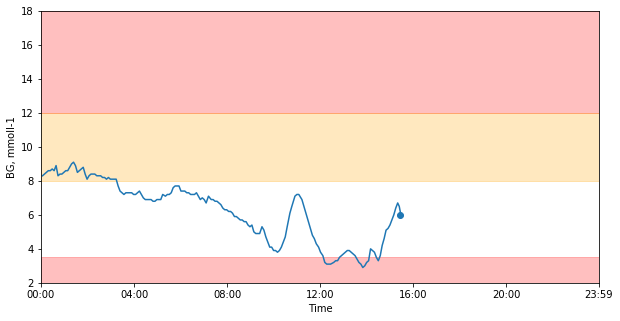

In [4]:
fig, ax = plt.subplots(1,1,figsize=[10,5])
bg.plot_daily_BG(df, datetime.date.today(), ax)

bg.add_daily_scatter(df, datetime.date.today(), ax)
plt.show()

## This week's BGs

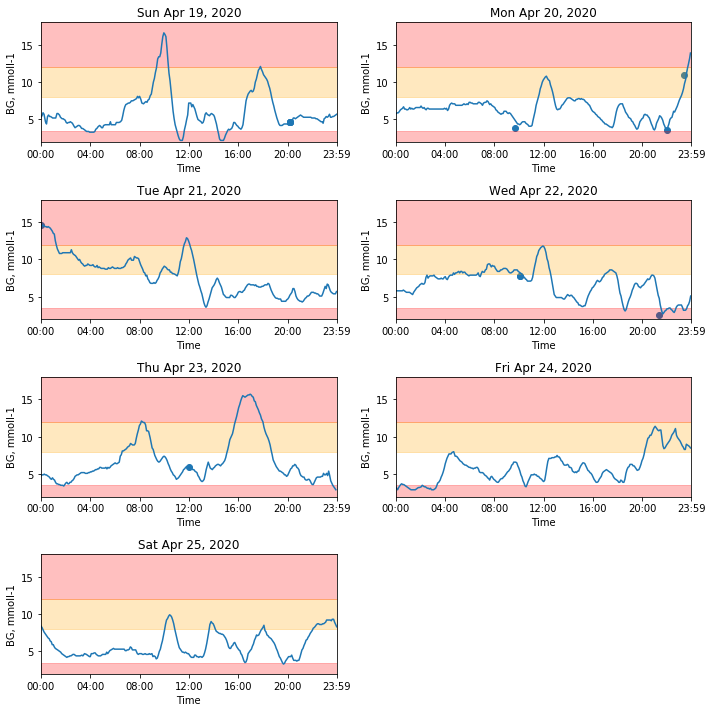

In [5]:
plt.rcParams['figure.figsize'] = [10, 10]
sunday = bg.lastWday(datetime.date.today() - datetime.timedelta(days=0), 6)
weekdays = ['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat']

fig2, ax2 = plt.subplots(4,2, figsize=[10,10])
for didx in range(7):
    date = sunday + datetime.timedelta(days=didx)
    axidx = (int(math.floor(didx/2)), didx % 2)
    if date <= datetime.date.today():
        bg.plot_daily_BG(df, date, ax2[axidx])
        bg.add_daily_scatter(df, date, ax2[axidx])
        ax2[axidx].set_title(date.strftime("%a %b %d, %Y"))
    else:
        ax2[axidx].set_visible(False)
ax2[-1,1].set_visible(False)
plt.tight_layout()

## Save weekly plots

Empty 'DataFrame': no numeric data to plot
Empty 'DataFrame': no numeric data to plot


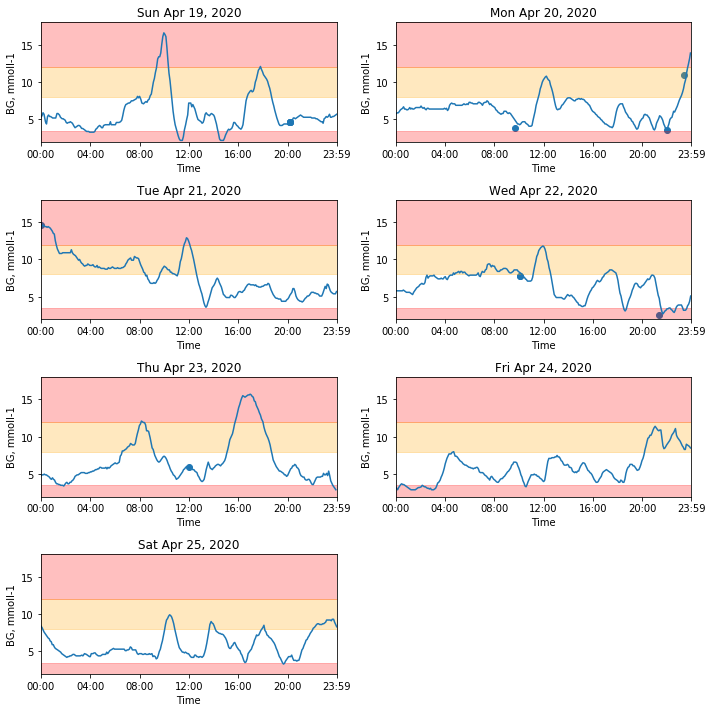

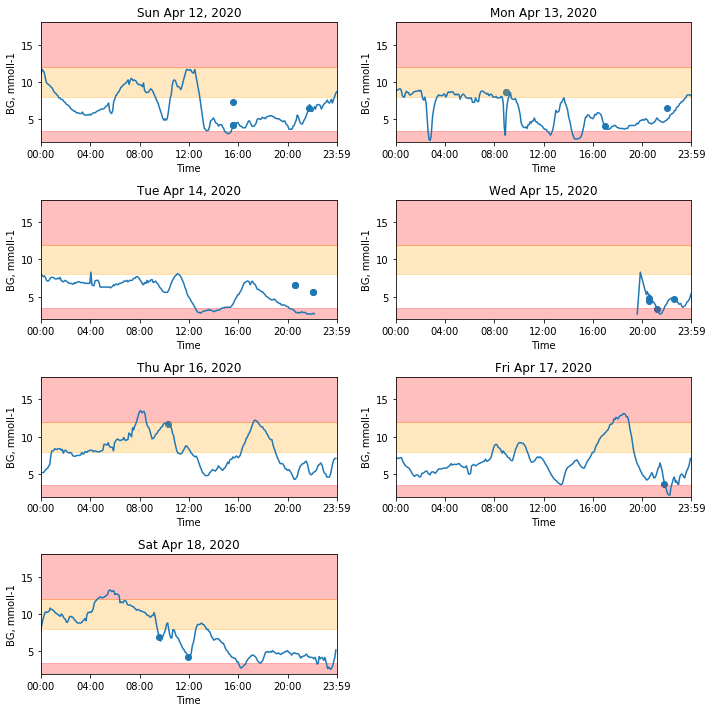

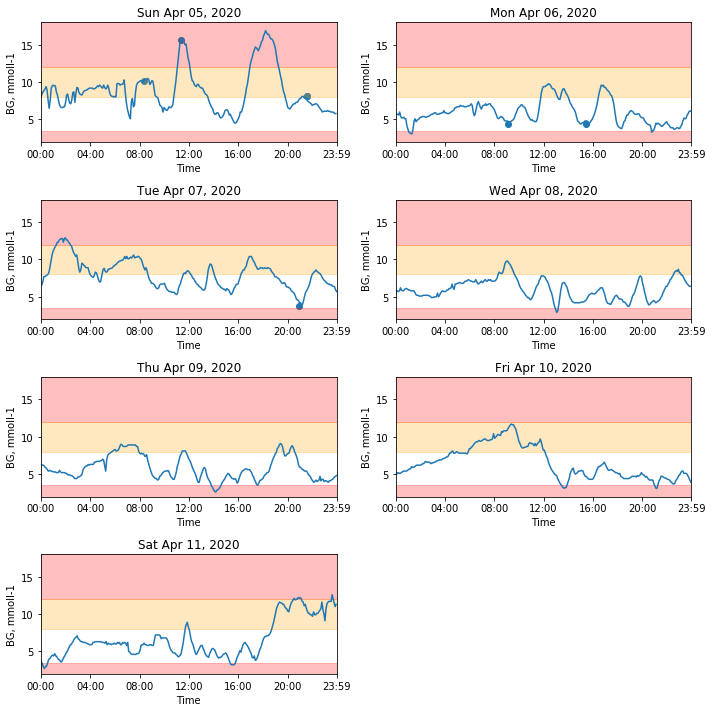

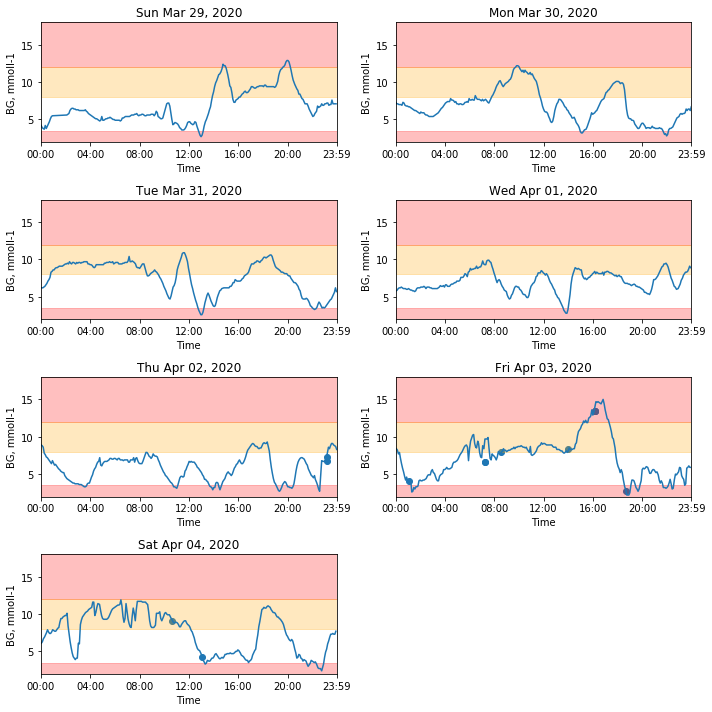

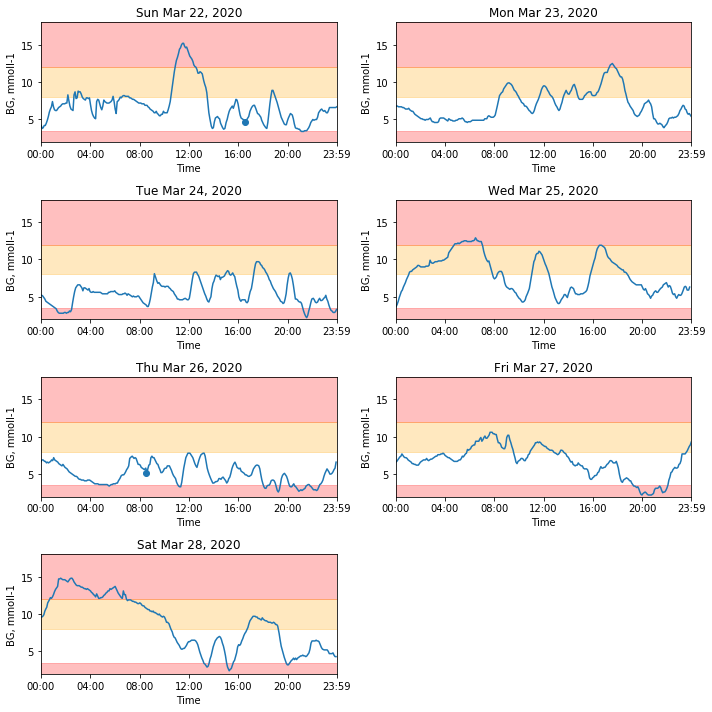

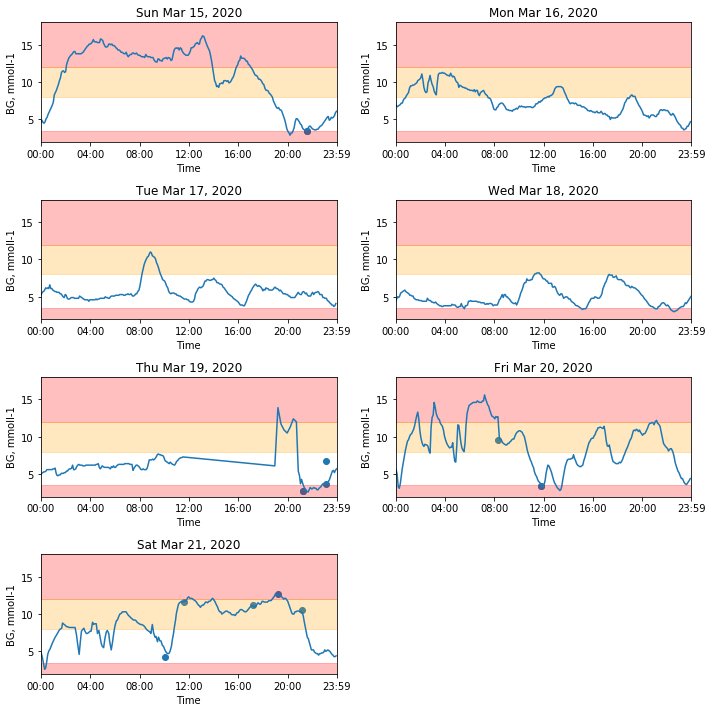

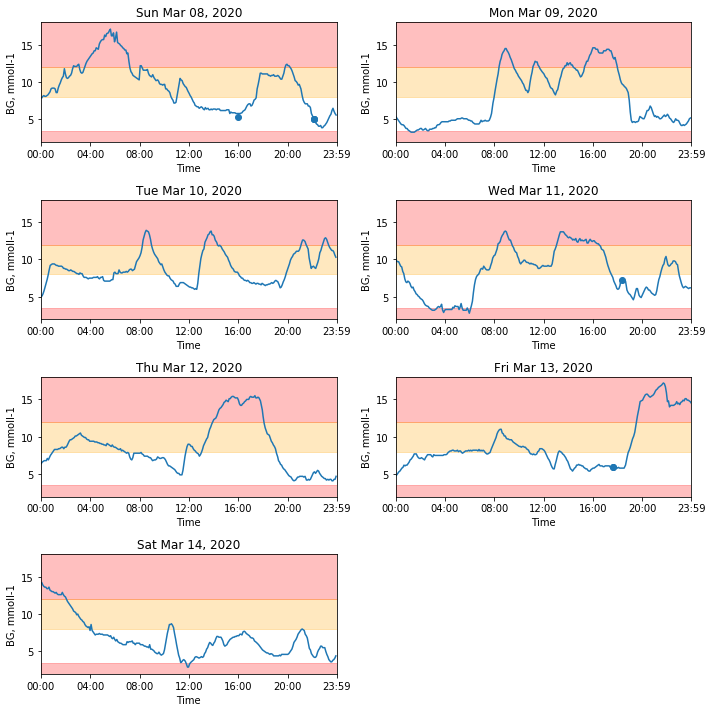

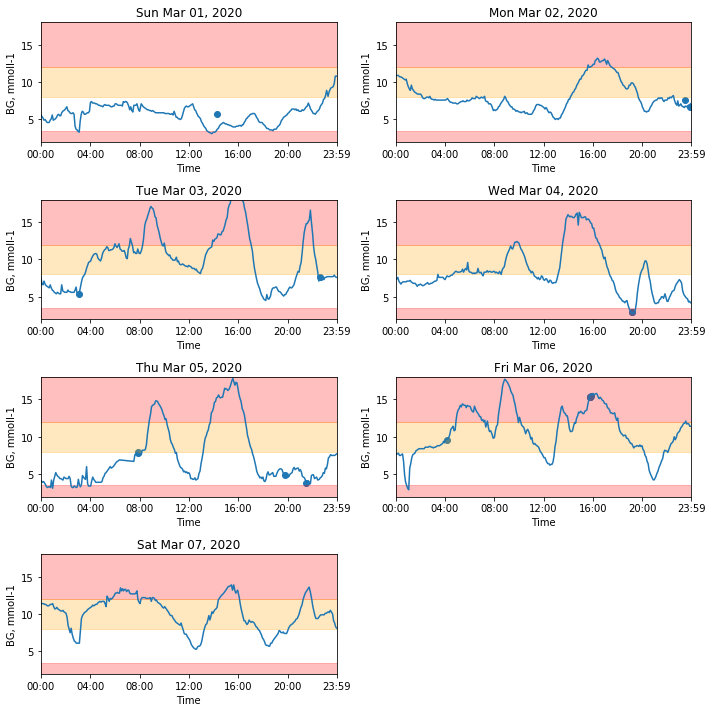

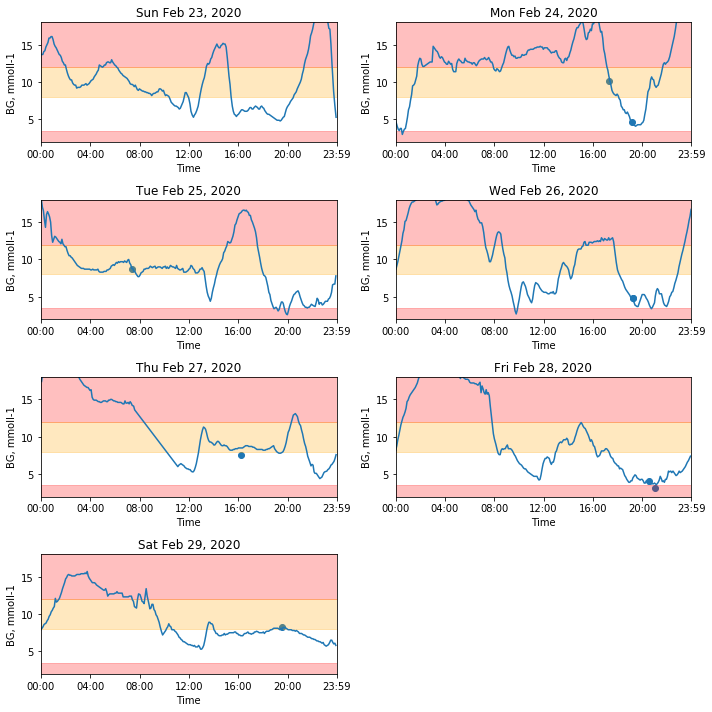

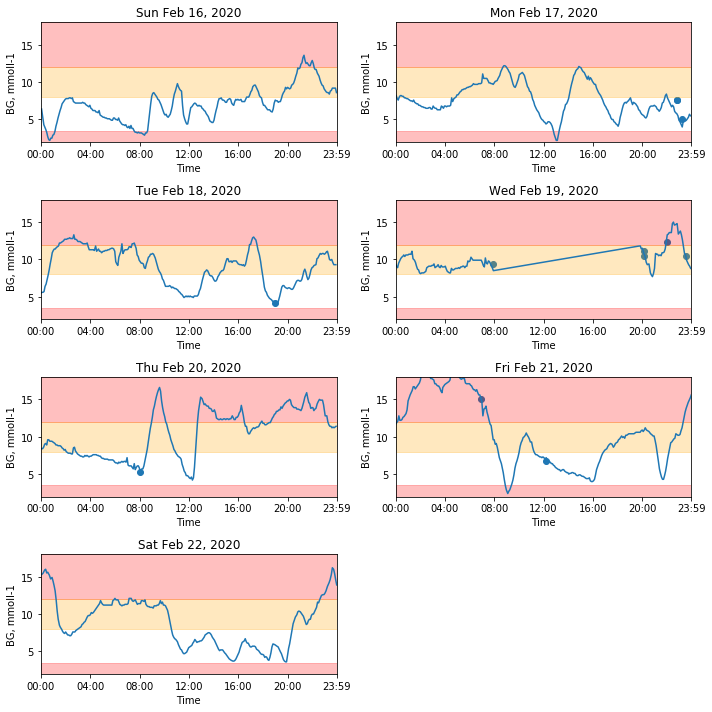

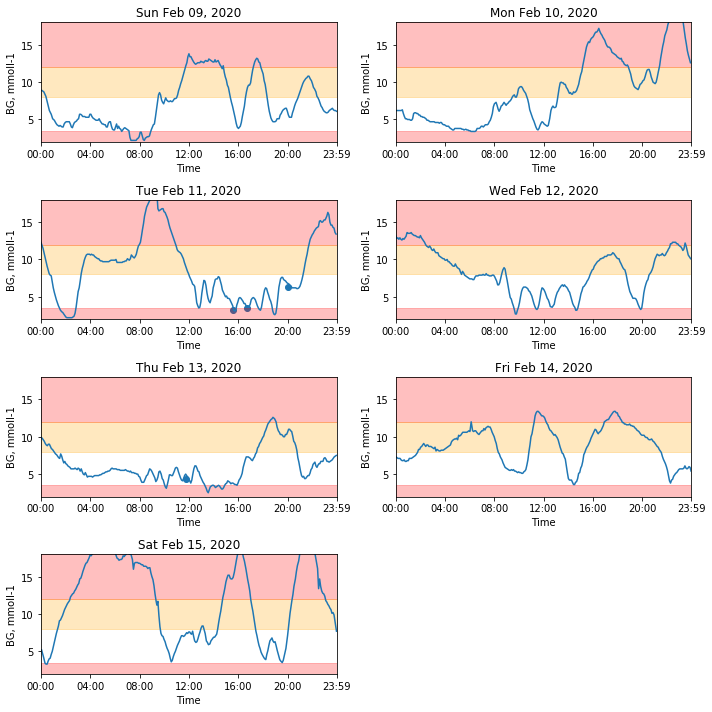

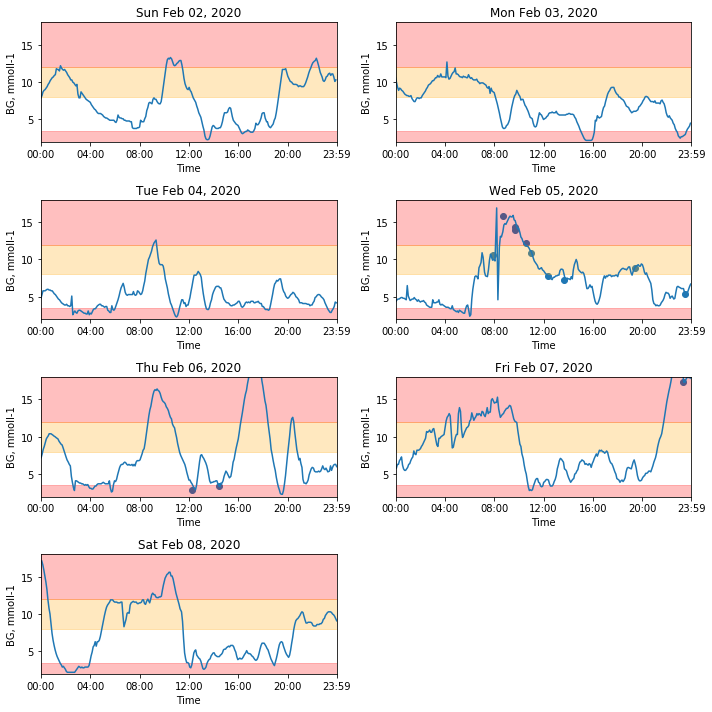

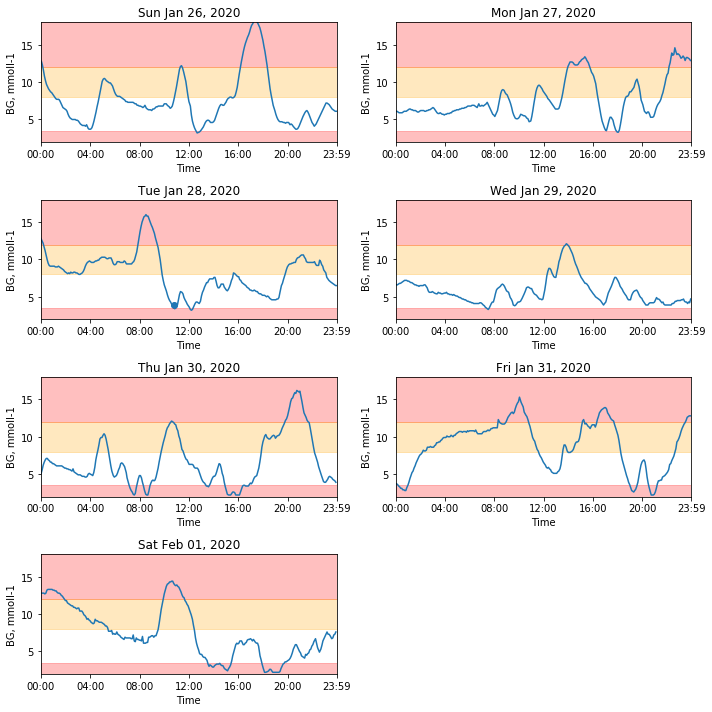

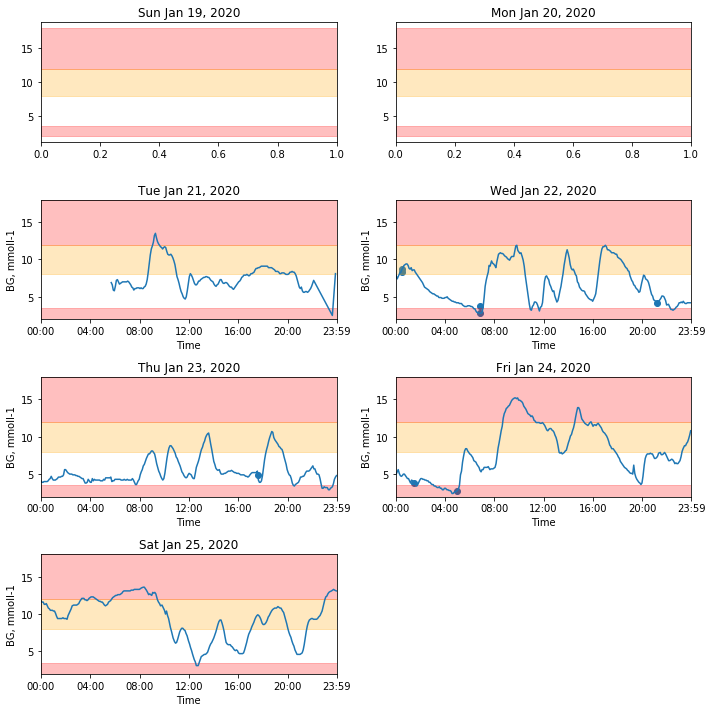

In [7]:
for weekidx in range(14):
    sunday = bg.lastWday(datetime.date.today() - datetime.timedelta(days=weekidx*7), 6)

    fig2, ax2 = plt.subplots(4,2, figsize=[10,10])
    for didx in range(7):
        date = sunday + datetime.timedelta(days=didx)
        axidx = (int(math.floor(didx/2)), didx % 2)
        if date <= datetime.date.today():
            try:
                bg.plot_daily_BG(df, date, ax2[axidx])
                bg.add_daily_scatter(df, date, ax2[axidx])
            except TypeError as e:
                print(e)
                pass
            ax2[axidx].set_title(date.strftime("%a %b %d, %Y"))
        else:
            ax2[axidx].set_visible(False)
    ax2[-1,1].set_visible(False)
    plt.tight_layout()
    fname = sunday.strftime("Week starting %Y-%m-%d.png")
    plt.savefig(os.path.join(outpath, fname))
    document.add_heading(sunday.strftime("Week starting %Y-%m-%d"), level=3)
    document.add_picture(os.path.join(outpath, fname), width=Inches(6.2))
# document.save(os.path.join(outpath, "Out doc 1.docx"))

## Long-term pattern spotting

Display a median/interquartile range line plot to show how blood sugar typically varies with time of day over a set period. Also display the percentage of time spent within set limits at different distinct times of day, and a colormap showing the occurance of hypoglycaemic episodes over a long period. 

In [8]:
time_band_targetses = [];
time_band_targetses.append(TimeBandTargets());
time_band_targetses.append(TimeBandTargets(time_band_name='Pre-breakfast',
                                           time_start_end=(7,8),
                                           target_bg=(4.0, 8.0)))
time_band_targetses.append(TimeBandTargets(time_band_name='Pre-lunch',
                                           time_start_end=(10.5,12),
                                           target_bg=(3.5, 8.0)))
time_band_targetses.append(TimeBandTargets(time_band_name='Pre-dinner',
                                           time_start_end=(16,18),
                                           target_bg=(3.5, 8.0)))

def long_term_pattern_spotting(df, n_days, enddate=None, outpath=None, desc_str=None, document=document):
    plt.rcParams['figure.figsize'] = [9, 9]
    if enddate is None:
        enddate = datetime.date.today()
    df = df[df['BG, mmoll-1'].notnull()]
    startdate = enddate - datetime.timedelta(days=n_days)
    # %prun ax = bg.plot_long_term_BG(df, startdate, enddate, time_smoothing_s=600)
    ax = bg.plot_long_term_BG(df, startdate, enddate, time_smoothing_s=600, outpath=outpath, desc_str=desc_str, document=document)
#     ax.set_ylim([2, 15])
    
    output = bg.percentageTimeInTarget(df, startdate, enddate, time_band_targetses, outpath=outpath, desc_str=desc_str, document=document);
    bg.plot_hypos(df, startdate, enddate, outpath=outpath, desc_str=desc_str, document=document);
    

In [9]:
# for display...
tbt_df = pd.DataFrame(columns=["Period", "Start time", "End time", "Lower bound", "Upper bound"])
tbt_df['Period'] = [tbt.time_band_name for tbt in time_band_targetses]
tbt_df['Start time'] = [datetime.time(int(tbt.time_start_end[0]), 
                                      int(60 * (tbt.time_start_end[0] - int(tbt.time_start_end[0])))) for tbt in time_band_targetses]
tbt_df['End time'] = [datetime.time(int(tbt.time_start_end[1]), 
                                      int(60 * (tbt.time_start_end[1] - int(tbt.time_start_end[1])))) for tbt in time_band_targetses]
tbt_df['Lower bound'] = [tbt.target_bg[0] for tbt in time_band_targetses]
tbt_df['Upper bound'] = [tbt.target_bg[1] for tbt in time_band_targetses]
tbt_df.head(n=6)

,Period,Start time,End time,Lower bound,Upper bound
0,Overnight,00:00:00,07:00:00,5.0,9.0
1,Pre-breakfast,07:00:00,08:00:00,4.0,8.0
2,Pre-lunch,10:30:00,12:00:00,3.5,8.0
3,Pre-dinner,16:00:00,18:00:00,3.5,8.0


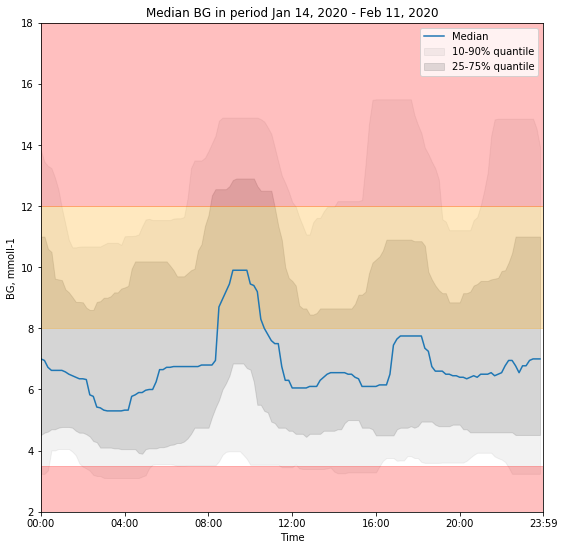

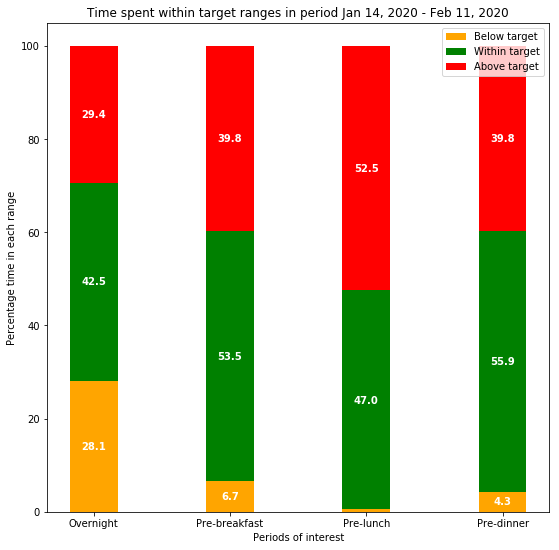

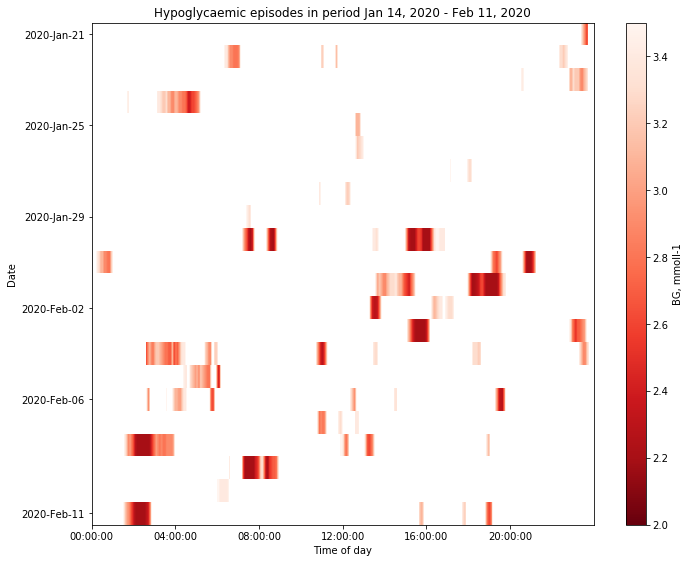

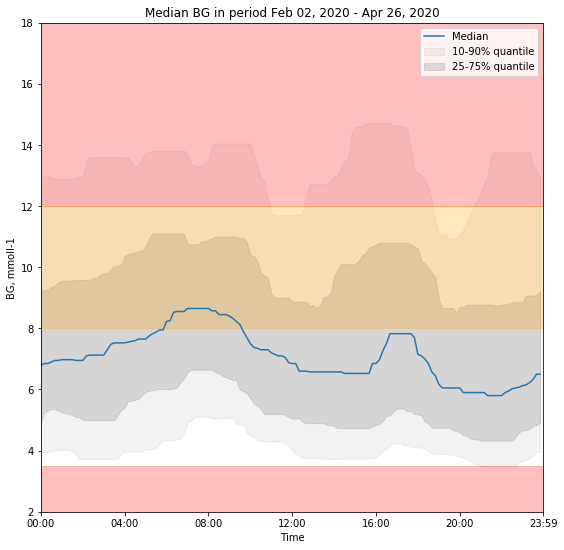

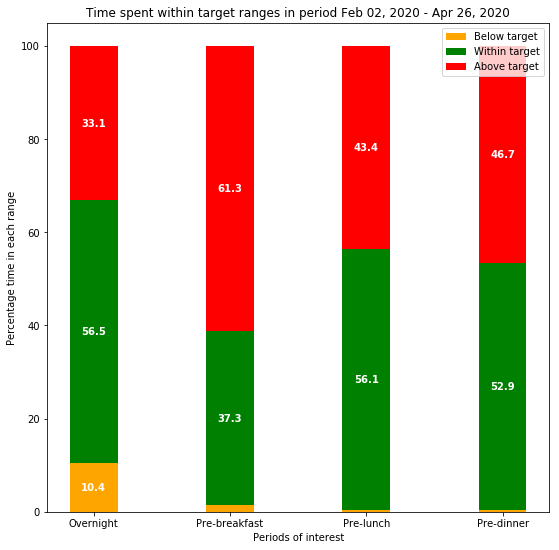

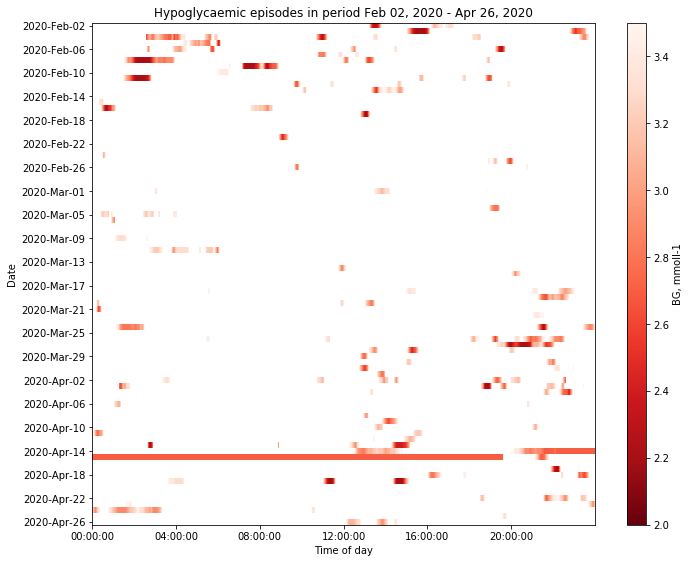

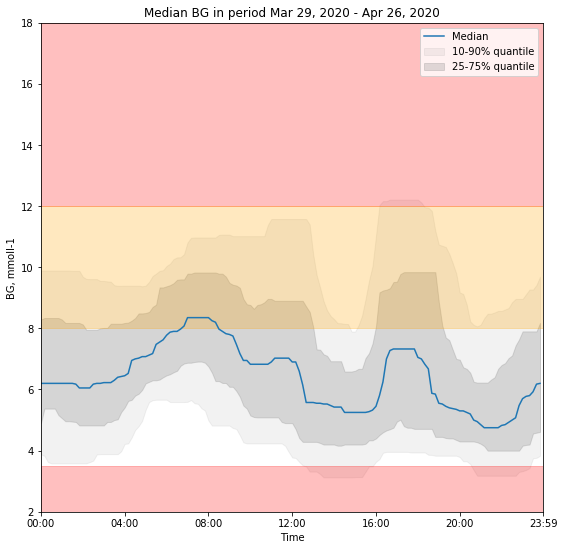

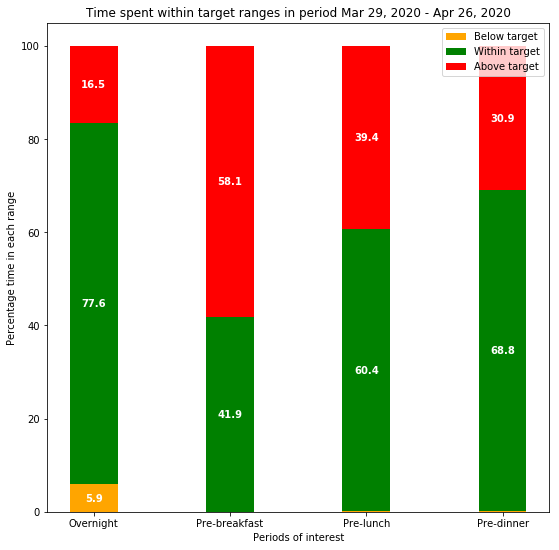

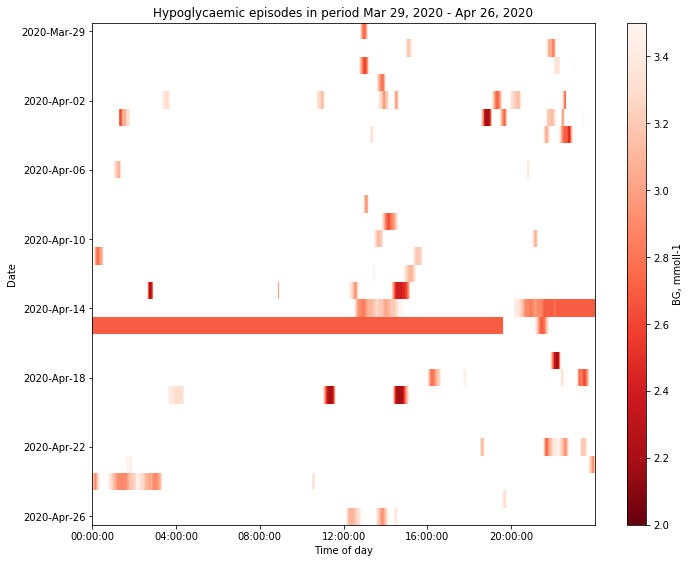

In [13]:
outpath = "C:\\Users\\Doug\\Desktop\\BG data\\visit 28-04-2019 review"
document = Document()
document.add_heading("Clinic 28-04-2019")

long_term_pattern_spotting(df, 28, enddate=datetime.date(2020, 2, 11), outpath=outpath, desc_str="Pre-pump ", document=document)
long_term_pattern_spotting(df, 3*28, outpath=outpath, desc_str="Last 3 months ", document=document)
long_term_pattern_spotting(df, 28, outpath=outpath, desc_str="Last month ", document=document)

document.save(os.path.join(outpath, "Long term summaries.docx"))

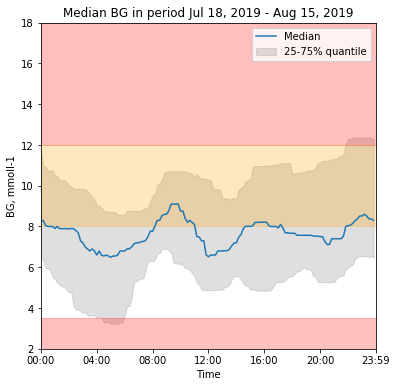

In [10]:
# plt.rcParams['figure.figsize'] = [2.95, 2.95] # 7.5 cm high
plt.rcParams['figure.figsize'] = [6, 6]
enddate = datetime.date.today()
startdate = datetime.date.today() - datetime.timedelta(days=28*1)
# %prun ax = bg.plot_long_term_BG(df, startdate, enddate, time_smoothing_s=600)
ax = bg.plot_long_term_BG(df, startdate, enddate, time_smoothing_s=600)

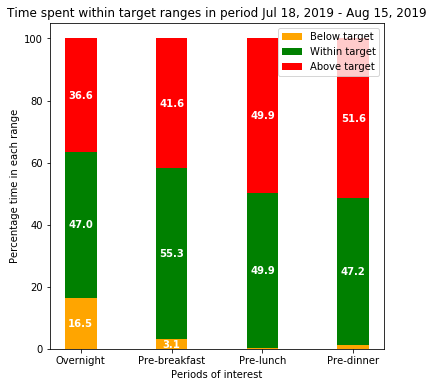

In [11]:


output = bg.percentageTimeInTarget(df, startdate, enddate, time_band_targetses);

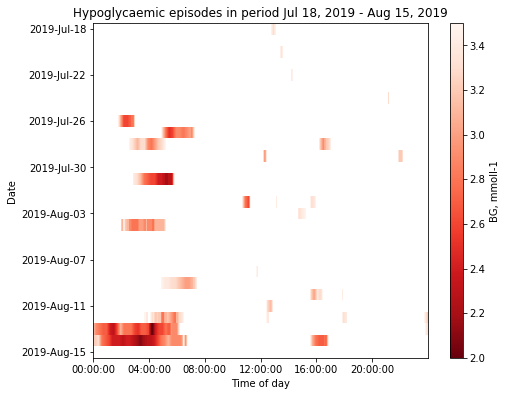

In [12]:
# %prun bg.plot_hypos(df, startdate, enddate)
bg.plot_hypos(df, startdate, enddate);

In [11]:
document.save(os.path.join(outpath, "Long term summaries document.docx"))